In [181]:
import pandas as pd  # для создание базы данных из получившихся сведений для дальнейшей обработки
import bs4  # для извлечения данных со страницы сайта
import requests # для работы с извлеченными данными
from youtube_search import YoutubeSearch # для вывода результатов при поиске на ютубе
# Следующие модули необязательные и добавлены исключительно для наблюдения за процессом парсинга
import time  # для подсчета затрчиваемого времени
from IPython.display import clear_output # отчищает вывод
import matplotlib.pyplot as plt # строит график

In [247]:
# Сброс ограничений на количество выводимых рядов
#pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
#pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [255]:
def get_date(soup):
    #Получение даты выпуска
    date =[]
    for i in soup.find_all('img', {'class':"attachment-bam-featured size-bam-featured wp-post-image"}):
        for i in [i['alt'].split(' — ')]:
            if len(i)>1:
                date+=[i[0].split(' ')[2]]
            else:
                date+=['-']
    return date

def get_name(soup):
    #Получение названия передачи
    name =[]
    for i in soup.find_all('img', {'class':"attachment-bam-featured size-bam-featured wp-post-image"}):
        for i in [i['alt'].split(' — ')]:
            if len(i)>1:
                name+=[i[1]]
            else:
                name+=[i[0]]
    return name

def get_url(soup):
    url = [i['href'] for i in soup.find_all('a', {'aria-hidden':"true"})]
    return url

def get_description(soup):
    #Получение описания
    try:
        description = [' '.join([tag.contents[0] for tag in bs4.BeautifulSoup(requests.get(i['href'] ).text, "html.parser")('p')[2:4]]) for i in soup.find_all('a', {'aria-hidden':"true"})]
    except:
        url_ = [i['href'] for i in soup.find_all('a', {'aria-hidden':"true"})]
        soup_ = [bs4.BeautifulSoup(requests.get(i).text, "html.parser") for i in url_]
        _soup = [soup.find_all('div', {'class': "entry-content"}) for soup in soup_]
        description = [' '.join([i.contents[0] for i in soup[0]('p') if type(i.contents[0]) == bs4.element.NavigableString]) for soup in _soup]
    
    # Отчистка от стандартной фраыз в начале.
    for i, d in enumerate(description):
        try:
            description[i] = d.split('года на Первом канале. ')[1]
        except:
            description[i] = d
    return description

def get_views(soup):
    # Поиск выпуска на ютубе и суммирование колличества просмотров всех видео с ним. 
    views = []
    for find in name(soup):
        results = YoutubeSearch(f'мужское женское {find}', max_results=10).to_dict()
        results = [d for d in results if find in d['title']]
        v = [d['views'] for d in results if 'мужское' in d['title'] or 
                                            'Мужское' in d['title'] or 
                                            'женское' in d['title'] or 
                                            'Женское' in d['title'] or 
                                            'выпуск' in d['title'] or 
                                            'Выпуск' in d['title']]
        if len(v) == 0:
            v = 0
        else:
            v = sum([int(v_i.split(' ')[0].replace(u'\xa0', u''))for v_i in v])
        views += [v]
    return views

def get_df(soup):
    #Запись все в датафрейм
    df = pd.DataFrame({'Дата выпуска': get_date(soup),
                       'Название': get_name(soup),
                       'Ссылка': get_url(soup),
                       'Описание': get_description(soup),
                       'Суммарное кол-во просмотров' : get_views(soup)})
    return df

Возникло ошибок: 0
 Среднее время обработки составляет: 10.78052 секунд
 Осталось: 0.18 минут


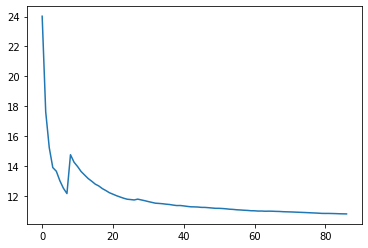

In [266]:
df = pd.DataFrame()
error_list = [] # собирает список страниц на которых могла возникнуть ошибка
t = [] # для подсчета времени
x = [] # затраченое время на обработку страницы
y = [] # номер страницы

# получаем колличество страниц на сайте и проходимся по каждой из них
number_of_pages = int([t.text for t in bs4.BeautifulSoup(requests.get(f'https://m-zh.ru/page/1').text, "html.parser").
                       find_all('a', {'class':'page-numbers'})][-2])
for n in range(number_of_pages):
    start = time.time() # время начала операции
    try:
        soup = bs4.BeautifulSoup(requests.get(f'https://m-zh.ru/page/{n}').text, "html.parser")
        df = pd.concat([df, get_df(soup)], ignore_index=True)
    except:
        error_list.append(n)
        print(f'Error with: {n}')
    end = time.time() # время завершения операции
    t += [end-start] # вычисляем затраченое время
    r = round(((sum(t)/len(t))*(number_of_pages-n))/60, 2) #вычисляем оставшееся время на проход по всем страницам
    
    clear_output(wait=True) # отчищаем вывод чтобы не происходило наслоения
    print(f'Возникло ошибок: {len(error_list)}\n',
          f'Среднее время обработки составляет: {sum(t)/len(t):.5f} секунд\n',
          f'Осталось: {r} минут')
    
    # рисуем граффик времени затраченой на операцию и номер операции
    x += [n]
    y += [sum(t)/len(t)]
    plt.plot(x, y)
    plt.show()
    
df.to_csv('МЖ.csv', index = False)